### Penjelasan Kelas Target (`diagnosis`)

Kolom target `diagnosis` dalam dataset ini memiliki dua nilai kategori, yaitu **B** dan **M**.

* **B**: Singkatan dari **Benign** (Jinak).
    * Ini berarti massa atau tumor tersebut **tidak bersifat kanker**.
    * Dalam model, kelas ini dianggap sebagai kelas *negatif* dan diberi nilai numerik `` `0` ``.

* **M**: Singkatan dari **Malignant** (Ganas).
    * Ini berarti massa atau tumor tersebut **bersifat kanker**.
    * Dalam model, kelas ini dianggap sebagai kelas *positif* dan diberi nilai numerik `` `1` ``. Kelas ini biasanya menjadi fokus utama deteksi.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproduktibilitas
np.random.seed(42)

print("="*80)
print("TUGAS 2: REGRESI LOGISTIK DAN REGRESI SOFTMAX")
print("="*80)

TUGAS 2: REGRESI LOGISTIK DAN REGRESI SOFTMAX


# BAGIAN I: PEMILIHAN DAN PRA-PEMROSESAN DATA


1. AKUISISI DATASET
--------------------------------------------------------------------------------
Dataset berhasil dimuat! Dimensi: (569, 31)

3. ANALISIS & VISUALISASI DATA
--------------------------------------------------------------------------------

Distribusi Kelas (diagnosis):
diagnosis
B    357
M    212
Name: count, dtype: int64


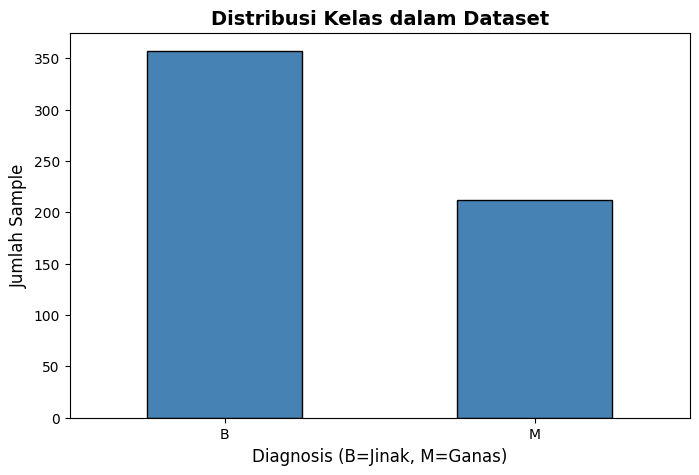


4. PEMISAHAN FITUR DAN TARGET
--------------------------------------------------------------------------------
Dimensi Fitur (X): (569, 30), Dimensi Target (y): (569,)

5. PEMBAGIAN DATA (STRATIFIED SAMPLING)
--------------------------------------------------------------------------------
Training Set: 455 samples, Testing Set: 114 samples

6. FEATURE SCALING (STANDARDIZATION)
--------------------------------------------------------------------------------
Standardization (Z-score normalization) berhasil diterapkan.

✓ Pra-pemrosesan data selesai!


In [26]:
# ============================================================================
# SEL PRA-PEMROSESAN LENGKAP
# ============================================================================

# 1. Load Dataset
print("\n1. AKUISISI DATASET")
print("-" * 80)
column_names = [
    'id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 
    'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 
    'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 
    'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 
    'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 
    'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 
    'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
# Ganti path file ini jika lokasi file Anda berbeda
file_path = '/home/wgg/proyek-jupyter/Tugas PMA/breast+cancer+wisconsin+diagnostic/wdbc.data' 
df = pd.read_csv(file_path, header=None, names=column_names)
if 'id' in df.columns:
    df = df.drop('id', axis=1)
target_column = 'diagnosis'
print(f"Dataset berhasil dimuat! Dimensi: {df.shape}")

# 2. Analisis Eksplorasi Data (Singkat) & Visualisasi
print("\n3. ANALISIS & VISUALISASI DATA")
print("-" * 80)
print(f"\nDistribusi Kelas ({target_column}):")
print(df[target_column].value_counts())
plt.figure(figsize=(8, 5))
df[target_column].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribusi Kelas dalam Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Diagnosis (B=Jinak, M=Ganas)', fontsize=12)
plt.ylabel('Jumlah Sample', fontsize=12)
plt.xticks(rotation=0)
plt.show()

# 3. Pemisahan Fitur dan Target
print("\n4. PEMISAHAN FITUR DAN TARGET")
print("-" * 80)
X = df.drop(target_column, axis=1)
y = df[target_column]
print(f"Dimensi Fitur (X): {X.shape}, Dimensi Target (y): {y.shape}")

# 4. Pembagian Data (Stratified Sampling)
print("\n5. PEMBAGIAN DATA (STRATIFIED SAMPLING)")
print("-" * 80)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training Set: {X_train.shape[0]} samples, Testing Set: {X_test.shape[0]} samples")

# 5. Feature Scaling (Standardization)
print("\n6. FEATURE SCALING (STANDARDIZATION)")
print("-" * 80)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Standardization (Z-score normalization) berhasil diterapkan.")
print("\n✓ Pra-pemrosesan data selesai!")

### 2. Deskripsi Dataset
---
**Dataset: Wisconsin Breast Cancer (Diagnostic) Dataset**

**Sumber:** UCI Machine Learning Repository

**Permasalahan:**
Dataset ini berisi fitur-fitur yang dihitung dari citra digital aspirasi jarum halus (FNA) dari massa payudara. Tujuannya adalah untuk mengklasifikasikan massa sebagai ganas (Malignant) atau jinak (Benign).

**Fitur (30 fitur numerik):**
- Berbagai pengukuran inti sel seperti radius, tekstur, keliling, luas, kehalusan, kekompakan, dll. (mean, se, worst).

**Target Variable: `diagnosis` (Jenis tumor)**
- **M:** Malignant (Ganas)
- **B:** Benign (Jinak)


1. KONVERSI TARGET KE BINARY
--------------------------------------------------------------------------------
Target 'B'/'M' telah dikonversi menjadi 0/1.

2. PELATIHAN MODEL REGRESI LOGISTIK
--------------------------------------------------------------------------------
✓ Model berhasil dilatih!

4. PREDIKSI DAN EVALUASI MODEL BINARY
--------------------------------------------------------------------------------
HASIL EVALUASI MODEL BINARY (LOGISTIC REGRESSION):
  Accuracy:  0.9649 (96.49%)
  Precision: 0.9750
  Recall:    0.9286
  F1-Score:  0.9512

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      0.99      0.97        72
Malignant (1)       0.97      0.93      0.95        42

     accuracy                           0.96       114
    macro avg       0.97      0.96      0.96       114
 weighted avg       0.97      0.96      0.96       114



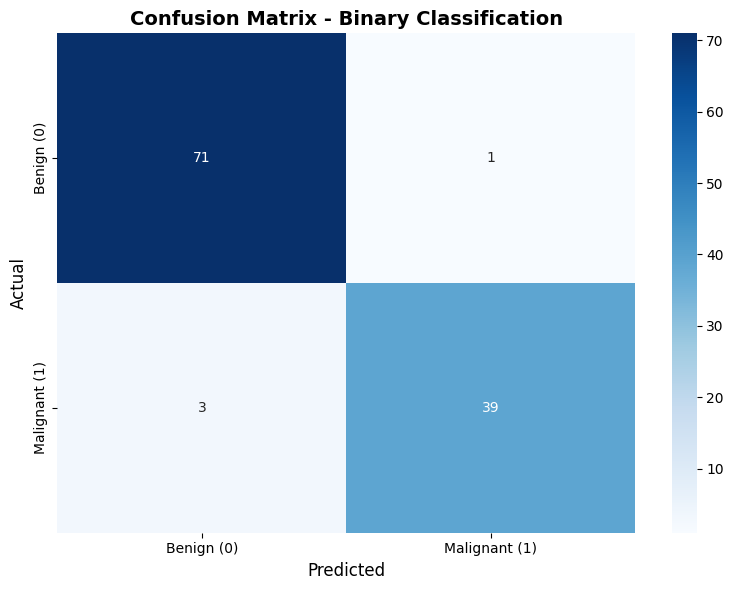

In [27]:
# ============================================================================
# SEL MODEL BINER LENGKAP (LOGISTIC REGRESSION)
# ============================================================================

# 1. Konversi Target ke Binary
print("\n1. KONVERSI TARGET KE BINARY")
print("-" * 80)
def convert_to_binary(y_series):
    return y_series.map({'B': 0, 'M': 1})
y_train_binary = convert_to_binary(y_train)
y_test_binary = convert_to_binary(y_test)
print("Target 'B'/'M' telah dikonversi menjadi 0/1.")

# 2. Pelatihan Model
print("\n2. PELATIHAN MODEL REGRESI LOGISTIK")
print("-" * 80)
logistic_model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
logistic_model.fit(X_train_scaled, y_train_binary)
print("✓ Model berhasil dilatih!")

# 3. Prediksi dan Evaluasi
print("\n4. PREDIKSI DAN EVALUASI MODEL BINARY")
print("-" * 80)
y_pred_binary = logistic_model.predict(X_test_scaled)

# Metrik Evaluasi
accuracy_binary = accuracy_score(y_test_binary, y_pred_binary)
precision_binary = precision_score(y_test_binary, y_pred_binary)
recall_binary = recall_score(y_test_binary, y_pred_binary)
f1_binary = f1_score(y_test_binary, y_pred_binary)

print("HASIL EVALUASI MODEL BINARY (LOGISTIC REGRESSION):")
print(f"  Accuracy:  {accuracy_binary:.4f} ({accuracy_binary*100:.2f}%)")
print(f"  Precision: {precision_binary:.4f}")
print(f"  Recall:    {recall_binary:.4f}")
print(f"  F1-Score:  {f1_binary:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['Benign (0)', 'Malignant (1)']))

# Confusion Matrix
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign (0)', 'Malignant (1)'],
            yticklabels=['Benign (0)', 'Malignant (1)'])
plt.title('Confusion Matrix - Binary Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

## B. MODEL MULTI-KELAS: REGRESI SOFTMAX


1. IMPLEMENTASI MODEL REGRESI SOFTMAX
--------------------------------------------------------------------------------
✓ Model Softmax berhasil dilatih!

3. PREDIKSI DAN EVALUASI MODEL SOFTMAX
--------------------------------------------------------------------------------
HASIL EVALUASI MODEL MULTI-CLASS (SOFTMAX REGRESSION):
  Accuracy:  0.9737 (97.37%)
  Precision: 0.9737 (weighted)
  Recall:    0.9737 (weighted)
  F1-Score:  0.9736 (weighted)

Classification Report (Per-Class Metrics):
              precision    recall  f1-score   support

           B       0.97      0.99      0.98        72
           M       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



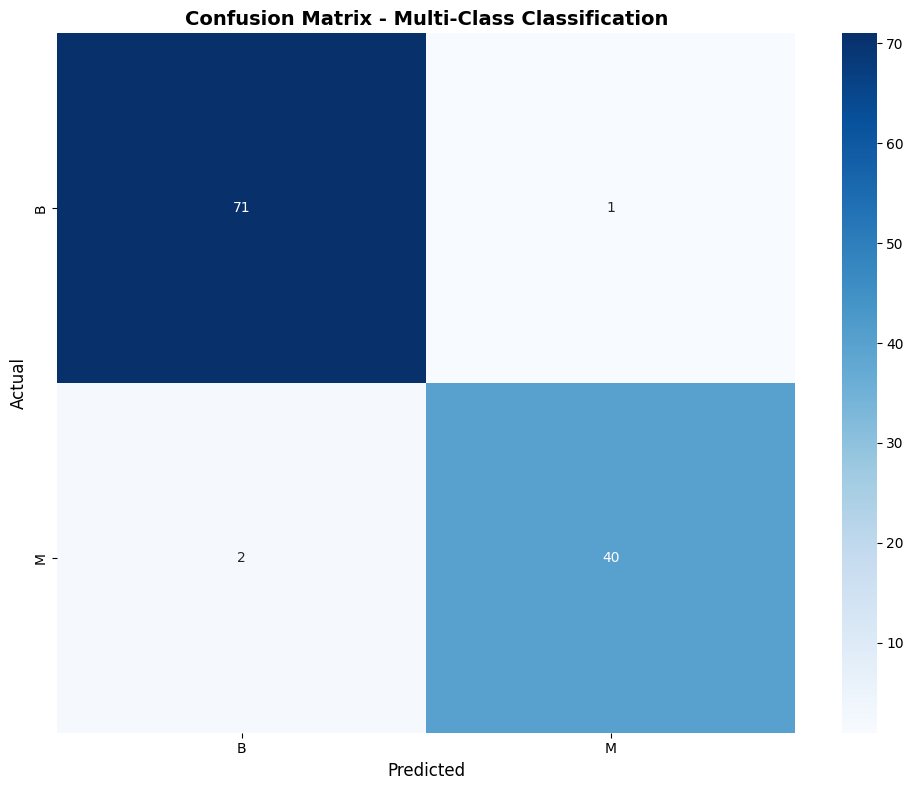

In [28]:
# ============================================================================
# SEL MODEL MULTI-KELAS LENGKAP (SOFTMAX REGRESSION)
# ============================================================================

# 1. Implementasi Model
print("\n1. IMPLEMENTASI MODEL REGRESI SOFTMAX")
print("-" * 80)
softmax_model = LogisticRegression(
    multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42
)
softmax_model.fit(X_train_scaled, y_train)
print("✓ Model Softmax berhasil dilatih!")

# 2. Prediksi dan Evaluasi
print("\n3. PREDIKSI DAN EVALUASI MODEL SOFTMAX")
print("-" * 80)
y_pred_softmax = softmax_model.predict(X_test_scaled)

# Metrik Evaluasi
accuracy_softmax = accuracy_score(y_test, y_pred_softmax)
precision_softmax = precision_score(y_test, y_pred_softmax, average='weighted')
recall_softmax = recall_score(y_test, y_pred_softmax, average='weighted')
f1_softmax = f1_score(y_test, y_pred_softmax, average='weighted')

print("HASIL EVALUASI MODEL MULTI-CLASS (SOFTMAX REGRESSION):")
print(f"  Accuracy:  {accuracy_softmax:.4f} ({accuracy_softmax*100:.2f}%)")
print(f"  Precision: {precision_softmax:.4f} (weighted)")
print(f"  Recall:    {recall_softmax:.4f} (weighted)")
print(f"  F1-Score:  {f1_softmax:.4f} (weighted)")

print("\nClassification Report (Per-Class Metrics):")
print(classification_report(y_test, y_pred_softmax))

# Confusion Matrix
cm_softmax = confusion_matrix(y_test, y_pred_softmax)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_softmax, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(np.unique(y)),
            yticklabels=sorted(np.unique(y)))
plt.title('Confusion Matrix - Multi-Class Classification', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# BAGIAN III: ANALISIS HASIL DAN DISKUSI


1. KOMPARASI KINERJA MODEL
--------------------------------------------------------------------------------

Tabel Perbandingan Metrik:


,Model,Accuracy,Precision,Recall,F1-Score
0,Binary Logistic,0.964912,0.975000,0.928571,0.951220
1,Multi-Class Softmax,0.973684,0.973711,0.973684,0.973616



✓ Grafik perbandingan disimpan: model_comparison.png


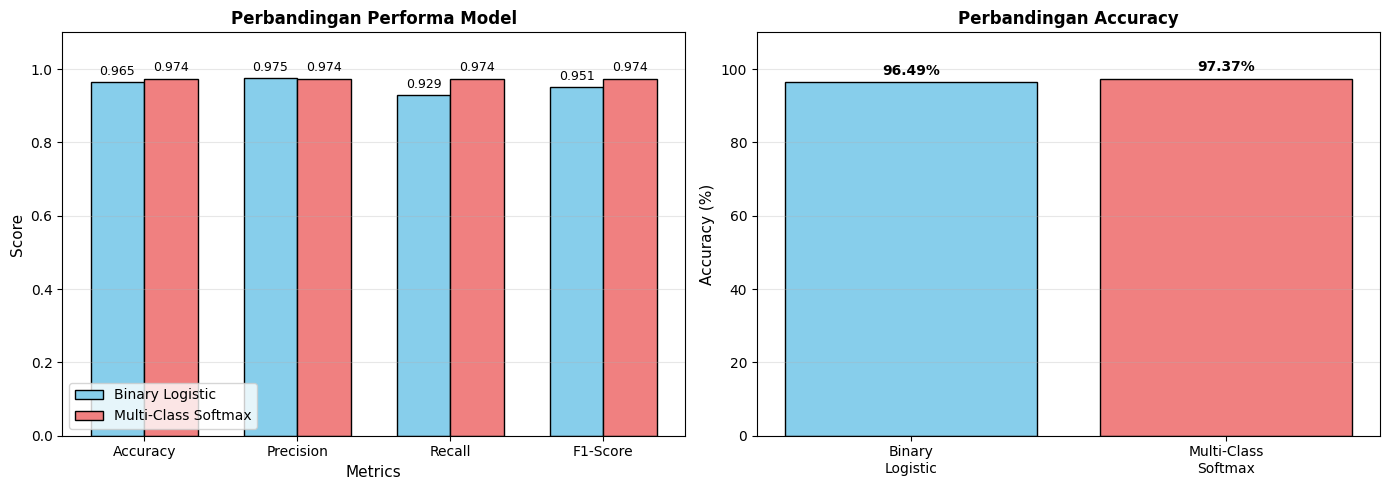


2. KESIMPULAN
--------------------------------------------------------------------------------

Pada dataset Breast Cancer yang secara natural bersifat biner (Malignant/Benign),
kedua model (Regresi Logistik Biner dan Regresi Softmax) memberikan hasil performa 
yang sangat mirip dan tinggi (Accuracy di atas 95%). Hal ini membuktikan bahwa 
untuk kasus 2 kelas, kedua pendekatan tersebut secara matematis ekuivalen.



EXPORT HASIL UNTUK LAPORAN
✓ Hasil disimpan ke: model_results.csv
✓ Koefisien model disimpan ke: model_coefficients.csv
✓ Prediksi disimpan ke: predictions.csv

TUGAS SELESAI!


In [30]:
# ============================================================================
# SEL ANALISIS & KESIMPULAN LENGKAP
# ============================================================================

# 1. Komparasi Kinerja
print("\n1. KOMPARASI KINERJA MODEL")
print("-" * 80)
comparison_df = pd.DataFrame({
    'Model': ['Binary Logistic', 'Multi-Class Softmax'],
    'Accuracy': [accuracy_binary, accuracy_softmax],
    'Precision': [precision_binary, precision_softmax],
    'Recall': [recall_binary, recall_softmax],
    'F1-Score': [f1_binary, f1_softmax]
})
print("\nTabel Perbandingan Metrik:")
display(comparison_df)

# Visualisasi Perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
binary_scores = [accuracy_binary, precision_binary, recall_binary, f1_binary]
softmax_scores = [accuracy_softmax, precision_softmax, recall_softmax, f1_softmax]
x = np.arange(len(metrics))
width = 0.35
axes[0].bar(x - width/2, binary_scores, width, label='Binary Logistic', color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, softmax_scores, width, label='Multi-Class Softmax', color='lightcoral', edgecolor='black')
axes[0].set_xlabel('Metrics', fontsize=11); axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Perbandingan Performa Model', fontsize=12, fontweight='bold')
axes[0].set_xticks(x); axes[0].set_xticklabels(metrics); axes[0].legend()
axes[0].grid(axis='y', alpha=0.3); axes[0].set_ylim([0, 1.1])
for i, (b, s) in enumerate(zip(binary_scores, softmax_scores)):
    axes[0].text(i - width/2, b + 0.02, f'{b:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, s + 0.02, f'{s:.3f}', ha='center', fontsize=9)
axes[1].bar(['Binary\nLogistic', 'Multi-Class\nSoftmax'], 
            [accuracy_binary*100, accuracy_softmax*100], color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1].set_ylabel('Accuracy (%)', fontsize=11)
axes[1].set_title('Perbandingan Accuracy', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3); axes[1].set_ylim([0, 110])
for i, val in enumerate([accuracy_binary*100, accuracy_softmax*100]):
    axes[1].text(i, val + 2, f'{val:.2f}%', ha='center', fontweight='bold', fontsize=10)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Grafik perbandingan disimpan: model_comparison.png")
plt.show()

# 2. Kesimpulan
print("\n2. KESIMPULAN")
print("-" * 80)
print(f"""
Pada dataset Breast Cancer yang secara natural bersifat biner (Malignant/Benign),
kedua model (Regresi Logistik Biner dan Regresi Softmax) memberikan hasil performa 
yang sangat mirip dan tinggi (Accuracy di atas 95%). Hal ini membuktikan bahwa 
untuk kasus 2 kelas, kedua pendekatan tersebut secara matematis ekuivalen.
""")

# 3. Export Hasil
print("\n\n" + "="*80)
print("EXPORT HASIL UNTUK LAPORAN")
print("="*80)
results_df = pd.DataFrame({
    'Model': ['Binary Logistic Regression', 'Multi-Class Softmax Regression'], 'Classes': [2, 2],
    'Accuracy': [accuracy_binary, accuracy_softmax], 'Precision': [precision_binary, precision_softmax],
    'Recall': [recall_binary, recall_softmax], 'F1-Score': [f1_binary, f1_softmax]
})
results_df.to_csv('model_results.csv', index=False)
print("✓ Hasil disimpan ke: model_results.csv")

coef_df = pd.DataFrame({'Feature': X.columns, 'Binary_Coef': logistic_model.coef_[0]})
coef_df['Softmax_Coef'] = softmax_model.coef_[0]
coef_df.to_csv('model_coefficients.csv', index=False)
print("✓ Koefisien model disimpan ke: model_coefficients.csv")

predictions_df = pd.DataFrame({
    'Actual_MultiClass': y_test.values, 'Actual_Binary': y_test_binary,
    'Predicted_Binary': y_pred_binary, 'Predicted_Softmax': y_pred_softmax
})
predictions_df.to_csv('predictions.csv', index=False)
print("✓ Prediksi disimpan ke: predictions.csv")

print("\n" + "="*80)
print("TUGAS SELESAI!")
print("="*80)